In [2]:
import calendar
import datetime as dt
import logging
import os
from pathlib import Path
from matplotlib import pyplot as plt

import numpyro
import pandas as pd
import torch
import xarray as xr
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (
    aes,
    geom_line,
    geom_point,
    facet_wrap,
    geom_vline,
    ggplot,
    facet_grid,
    scale_x_datetime,
    geom_ribbon,
    theme,
    theme_bw,
    ylab,
    element_text,
    scale_color_brewer,
    geom_hline,
    geom_smooth,
    xlab,
    geom_boxplot,
    scale_x_continuous,
    element_blank,
)
from sklearn.gaussian_process import kernels
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.data_loading.data_loading import load_data
from src.modeling.ensemble import DefaultEnsemble, BoostedRegressor, RandomForest
from src.modeling.gaussian_process import SklearnGPModel, MultitaskGP, HierarchicalARGP
from src.modeling.lm import LinearModel
from src.modeling.metrics import summarize
from src.modeling.var_models import VAR, NARX
from src.preprocessing.preprocessing import (
    XArrayStandardScaler,
    SeasonalFeatures,
    XArrayFeatureUnion,
)
from src.utils import flatten_array
import jax


logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
# torch.set_default_device(device)

os.environ["JAX_PLATFORM_NAME"] = device

numpyro.set_platform(device)
numpyro.set_host_device_count(4)

# numpyro.set_platform("cuda")
# numpyro.set_host_device_count(1)

pd.options.display.float_format = "{:,.3f}".format

In [3]:
def rename_lakes(x):
    return {
        "eri": "Erie",
        "sup": "Superior",
        "mic_hur": "Michigan/Huron",
        "ont": "Ontario",
    }.get(x, x)


lake_data = (
    load_data(["rnbs", "precip", "temp", "evap"])
    .sel(type=["Water", "Land", "Basin"])
    .dropna("Date")
    .to_array()
    .transpose("Date", "lake", ...)
)
lake_data

<xarray.DataArray (Date: 384, lake: 4, variable: 4, type: 3)> Size: 147kB
array([[[[-20.92372 , -20.92372 , -20.92372 ],
         [ 16.74    ,  10.85    ,  13.33    ],
         [262.3     , 255.1     , 258.3     ],
         [104.97    ,  21.45    ,  57.94    ]],

        [[ 40.5714  ,  40.5714  ,  40.5714  ],
         [ 24.955   ,  22.785   ,  23.25    ],
         [265.95    , 262.      , 263.25    ],
         [ 81.855   ,  25.485   ,  44.87    ]],

        [[ 93.83467 ,  93.83467 ,  93.83467 ],
         [ 26.66    ,  24.49    ,  24.8     ],
         [267.6     , 265.7     , 266.2     ],
         [ 44.02    ,  23.9     ,  29.08    ]],

        [[239.5306  , 239.5306  , 239.5306  ],
         [ 43.4     ,  41.54    ,  42.78    ],
         [267.7     , 265.6     , 266.3     ],
         [ 60.7     ,  30.94    ,  40.95    ]]],

...

       [[[-53.29011 , -53.29011 , -53.29011 ],
         [ 13.02    ,  14.26    ,  13.64    ],
         [269.      , 264.5     , 266.5     ],
         [ 93.62    ,  33.45    ,  59.74    ]],

        [[ -2.97982 ,  -2.97982 ,  -2.97982 ],
         [ 18.91    ,  17.36    ,  17.67    ],
         [270.95    , 267.95    , 269.      ],
         [ 97.235   ,  35.6     ,  57.455   ]],

        [[  0.      ,   0.      ,   0.      ],
         [ 17.36    ,  16.12    ,  16.12    ],
         [271.2     , 269.4     , 269.9     ],
         [ 72.91    ,  32.05    ,  42.62    ]],

        [[173.6947  , 173.6947  , 173.6947  ],
         [ 28.52    ,  27.9     ,  28.83    ],
         [270.8     , 268.6     , 269.4     ],
         [ 81.53    ,  37.04    ,  53.72    ]]]])
Coordinates:
  * Date      (Date) datetime64[ns] 3kB 1979-01-01 1979-02-01 ... 2010-12-01
  * lake      (lake) object 32B 'sup' 'mic_hur' 'eri' 'ont'
  * type      (type) object 24B 'Water' 'Land' 'Basin'
  * variable  (variable) object 32B 'rnbs' 'precip' 'temp' 'evap'
Attributes:
    source:   GLCC

In [4]:
num_splits = 5
forecast_steps = 13

test_data = lake_data.sel(Date=slice("2006", "2010"))
train_data = lake_data.sel(Date=slice(None, "2005"))

splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps, gap=0)
splits = list(splitter.split(train_data))

X, y = train_data.sel(variable=["precip", "temp", "evap"]), train_data.sel(
    variable=["rnbs"], type="Water"
).squeeze().drop_vars(["variable", "type"])
test_x, test_y = test_data.sel(variable=["precip", "temp", "evap"]), test_data.sel(
    variable=["rnbs"], type="Water"
).squeeze().drop_vars(["variable", "type"])

y_scaler = XArrayStandardScaler()
y = y_scaler.fit_transform(y)
test_y = y_scaler.transform(test_y)
for train, test in splits:
    # print(X.indexes["Date"][train], X.indexes["Date"][test])
    print(len(train), X.indexes["Date"][test])

259 DatetimeIndex(['2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01',
               '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01',
               '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01',
               '2001-08-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
272 DatetimeIndex(['2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01',
               '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
285 DatetimeIndex(['2002-10-01', '2002-11-01', '2002-12-01', '2003-01-01',
               '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01',
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
298 DatetimeIndex(['2003-11-01', '2003-12-01', '2004-01-01', '2004-02-01'

In [5]:
plot_data = (
    lake_data.sel(variable="rnbs")
    .drop_vars(["variable", "type"])
    .to_dataframe(name="rnbs")
    .reset_index()
)

g1 = (
    ggplot(data=plot_data, mapping=aes(x="Date", y="rnbs"))
    + geom_line()
    + facet_wrap("~lake", labeller=rename_lakes)
    + theme_bw()
    + theme(axis_title_x=element_blank(), figure_size=(8, 4))
    + scale_x_datetime(labels=date_format(fmt="%Y"))
    + ylab("RNBS $\\left(mm\\right)$")
    + geom_vline(xintercept=dt.datetime(2006, 1, 1), linetype="--", color="red")
)

# g1.save("../../_scratch/images/raw_rnbs.png")

lake_data.indexes["lake"]

Index(['sup', 'mic_hur', 'eri', 'ont'], dtype='object', name='lake')

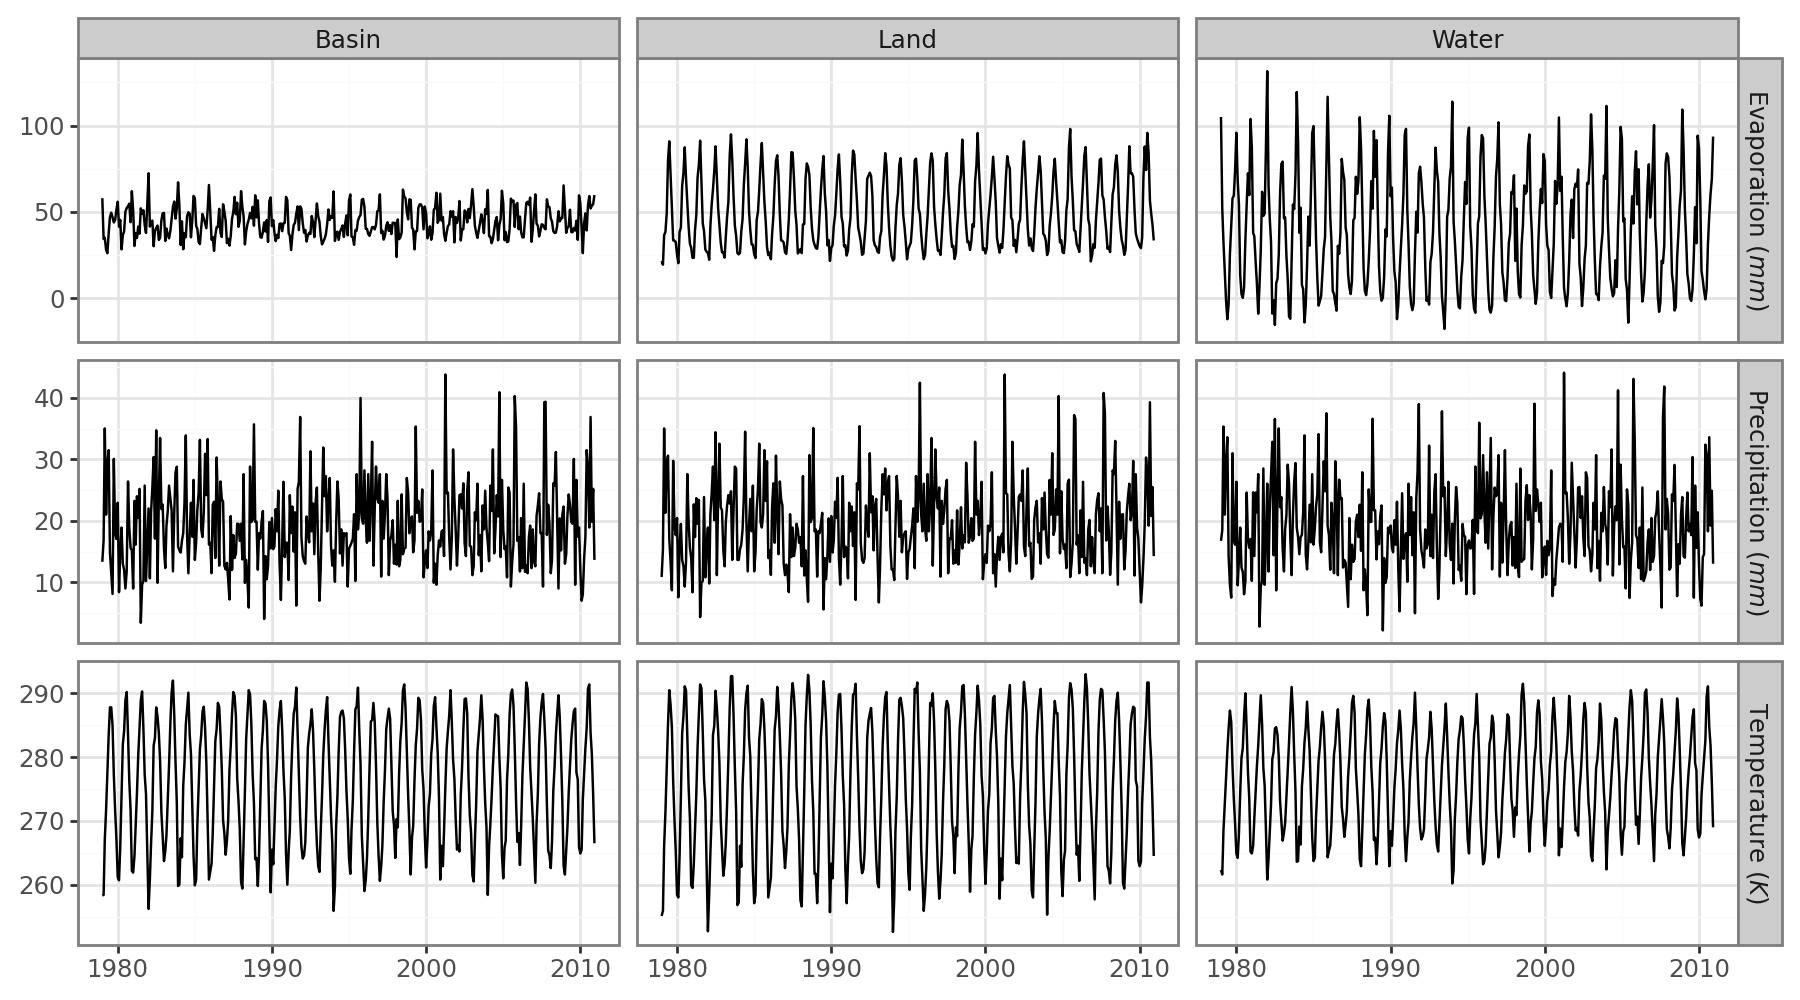

In [6]:
covar_data = (
    load_data(["precip", "temp", "evap"])
    .to_array()
    .sel(type=["Basin", "Land", "Water"], lake="sup")
    .
    # drop_vars("lake").
    dropna("Date")
    .transpose("Date", ...)
)

plot_data = covar_data.to_dataframe(
    dim_order=["Date", "type", "variable"], name="covar"
).reset_index()

(
    ggplot(data=plot_data, mapping=aes(x="Date", y="covar"))
    + geom_line()
    + facet_grid(
        "variable~type",
        scales="free_y",
        labeller=lambda x: {
            "evap": "Evaporation ($mm$)",
            "precip": "Precipitation ($mm$)",
            "temp": "Temperature ($K$)",
        }.get(x, x),
    )
    + theme_bw()
    + theme(axis_title=element_blank(), figure_size=(9, 5))
    + scale_x_datetime(labels=date_format(fmt="%Y"))
)

In [7]:
preprocessor = XArrayFeatureUnion(
    [
        (
            "preprocess",
            Pipeline(
                steps=[
                    ("scale", XArrayStandardScaler()),
                    ("flatten", FunctionTransformer(flatten_array)),
                ]
            ),
        ),
        ("seasonal", SeasonalFeatures()),
    ]
)

gp_models = {
    "GP_Matern": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                SklearnGPModel(
                    1.0 * kernels.Matern(nu=1.5) * kernels.RationalQuadratic()
                ),
            ),
        ]
    ),
    "MultitaskGP": Pipeline(
        steps=[("preprocess", preprocessor), ("model", MultitaskGP(epochs=100, rank=1))]
    ),
    # "HierarchicalARGP": Pipeline(
    #     steps=[("preprocess", preprocessor), ("model", HierarchicalARGP(num_samples=250, num_warmup=250, num_chains=4))]
    # ),
}

simple_models = {
    "SimpleLM": Pipeline(
        steps=[("preprocess", preprocessor), ("model", LinearModel())]
    ),
    "RF": Pipeline(steps=[("preprocess", preprocessor), ("model", RandomForest())]),
    "BoostedTrees": Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", BoostedRegressor(n_estimators=500, learning_rate=0.1)),
        ]
    ),
}

def lake_unstack(X_vals):
    return xr.concat(
        [flatten_array(arr) for arr in X_vals.transpose("lake", ...)], dim="lake"
    ).transpose("Date", "lake", "variable")

varx_models = {
    # "NARX": Pipeline(
    #     steps=[
    #         ("preprocess", preprocessor),
    #         (
    #             "model",
    #             NARX(
    #                 lags={"y": 3, "temp": 0, "precip": 0, "evap": 0},
    #                 num_warmup=1000,
    #                 num_chains=4,
    #                 num_samples=1000,
    #             ),
    #         ),
    #     ]
    # ),
    "VARX": Pipeline(
        steps=[
            ("preprocess", XArrayStandardScaler()),
            ("unstack", FunctionTransformer(lake_unstack)),
            (
                "model",
                VAR(
                    lags={"y": 3, "precip": 0, "temp": 0, "evap": 0},
                    num_warmup=1000,
                    num_chains=4,
                    num_samples=1000,
                ),
            ),
        ]
    ),
}


# use only temp and precip
all_models = {
    "Default": Pipeline(
        steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]
    ),
    **simple_models,
    **gp_models,
    **varx_models,
}

In [30]:
# run cross validation
results = []
overwrite = False
results_dir = Path("_scratch_all_types/results")
results_dir.mkdir(exist_ok=True, parents=True)
for name, model in all_models.items():
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        prediction_file = results_dir / f"{name}_{i}.csv"
        if prediction_file.exists() and not overwrite:
            logging.info(f"Loading {name} model (split {i + 1}/{num_splits})")
            predictions = pd.read_csv(prediction_file).assign(split=i + 1)
            predictions["Date"] = pd.to_datetime(predictions["Date"])
        else:
            logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
            model.fit(X[train_id], y[train_id])
            preds = model.predict(
                X[: max(test_id) + 1],
                y=y[:max(test_id) + 1],
                forecast_steps=forecast_steps,
                sample_subset=100,
            )

            array = xr.concat(
                [preds, y[test_id].expand_dims({"value": ["true"]}, axis=-1)],
                dim="value",
            )

            predictions = pd.concat(
                [
                    arr.to_pandas().assign(
                        months_ahead=list(range(1, forecast_steps + 1)), model=name
                    )
                    for arr in array.transpose("lake", ...)
                ],
                axis=0,
                keys=preds.lake.values,
                names=["lake"],
            ).assign(split=i + 1)
            predictions.to_csv(prediction_file)
        results.append(predictions)

cv_results = pd.concat(results, axis=0)
cv_results.head()

INFO:root:Fitting Default model...
INFO:root:Loading Default model (split 1/5)
INFO:root:Loading Default model (split 2/5)
INFO:root:Loading Default model (split 3/5)
INFO:root:Loading Default model (split 4/5)
INFO:root:Loading Default model (split 5/5)
INFO:root:Fitting SimpleLM model...
INFO:root:Loading SimpleLM model (split 1/5)
INFO:root:Loading SimpleLM model (split 2/5)
INFO:root:Loading SimpleLM model (split 3/5)
INFO:root:Loading SimpleLM model (split 4/5)
INFO:root:Loading SimpleLM model (split 5/5)
INFO:root:Fitting RF model...
INFO:root:Loading RF model (split 1/5)
INFO:root:Loading RF model (split 2/5)
INFO:root:Loading RF model (split 3/5)
INFO:root:Loading RF model (split 4/5)
INFO:root:Loading RF model (split 5/5)
INFO:root:Fitting BoostedTrees model...
INFO:root:Loading BoostedTrees model (split 1/5)
INFO:root:Loading BoostedTrees model (split 2/5)
INFO:root:Loading BoostedTrees model (split 3/5)
INFO:root:Loading BoostedTrees model (split 4/5)
INFO:root:Loading Boost

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

INFO:root:get_compile_options: no backend supplied; disabling XLA-AutoFDO profile
INFO:root:Loading VARX model (split 2/5)
INFO:root:Loading VARX model (split 3/5)
INFO:root:Loading VARX model (split 4/5)
INFO:root:Loading VARX model (split 5/5)


lake       Date   mean  lower  upper   std   true  months_ahead    model  \
0  sup 2000-08-01  0.267 -0.651  1.309 0.558 -0.299             1  Default   
1  sup 2000-09-01 -0.130 -1.088  0.935 0.599 -1.268             2  Default   
2  sup 2000-10-01 -0.187 -1.215  1.221 0.705 -0.974             3  Default   
3  sup 2000-11-01 -0.591 -1.357  1.009 0.713 -0.991             4  Default   
4  sup 2000-12-01 -1.093 -1.605 -0.201 0.402 -1.702             5  Default   

   split  
0      1  
1      1  
2      1  
3      1  
4      1

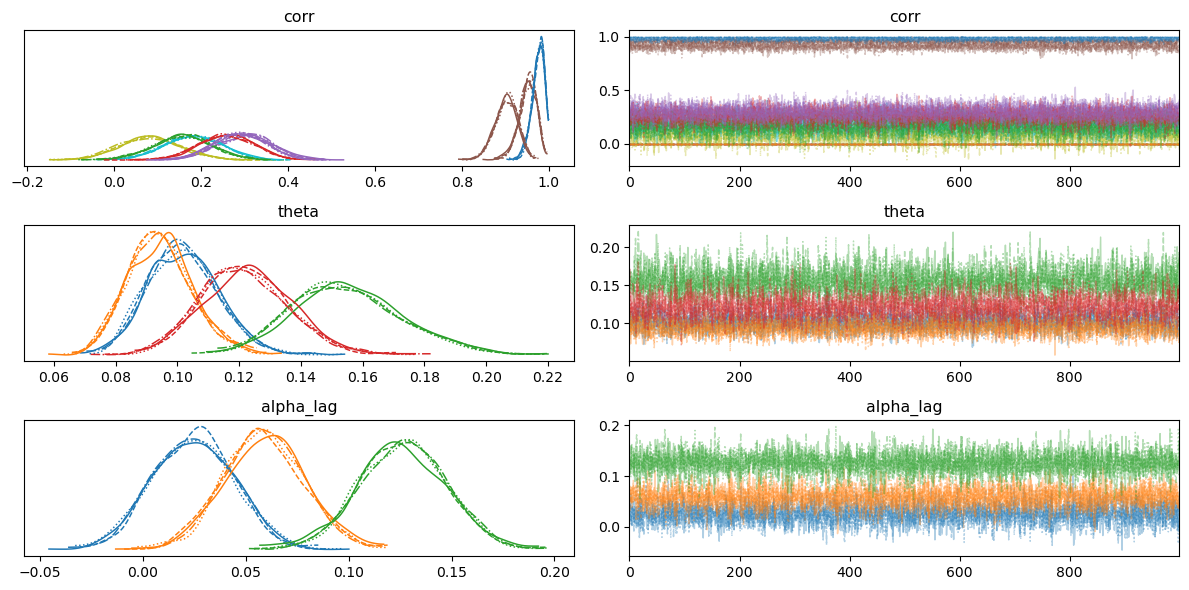

In [48]:
gp_model = model.steps[-1][1]

import arviz as az

az.plot_trace(
    gp_model.trace,
    var_names=["corr", "theta", "alpha_lag"],#, "alpha_lake", "intercept"],
    compact=True,
    figsize=(12, 6)
)
plt.tight_layout()
plt.show()

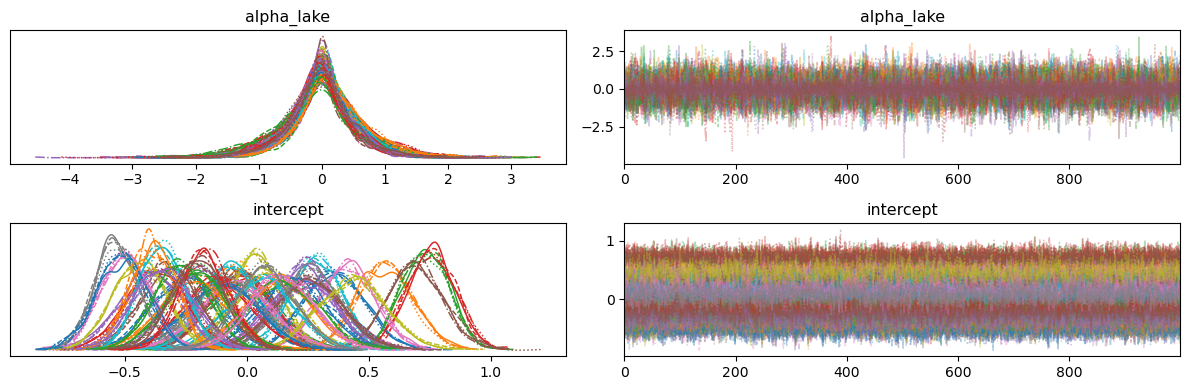

In [54]:
az.plot_trace(
    gp_model.trace,
    var_names=["alpha_lake", "intercept"],
    compact=True,
    figsize=(12, 4)
)
plt.tight_layout()
plt.show()

In [10]:
cv_results_12 = cv_results[cv_results["months_ahead"] <= 12].reset_index()
cv_results_12.groupby(["lake", "model"]).apply(summarize, include_groups=False)

rmse   mae   mape  variance   bias  coverage  \
lake    model                                                        
eri     BoostedTrees 0.469 0.378 10.518     0.220  0.014     0.883   
        Default      0.632 0.517  1.926     0.393  0.076     0.933   
        GP_Matern    0.397 0.308  3.202     0.156  0.043     0.933   
        MultitaskGP  0.437 0.344  1.677     0.189  0.040     0.917   
        RF           0.495 0.394  1.531     0.244  0.014     0.933   
        SimpleLM     0.483 0.373  1.894     0.229  0.066     0.833   
        VARX         0.420 0.323  0.988     0.175  0.037     0.900   
mic_hur BoostedTrees 0.403 0.344  1.013     0.160  0.055     0.833   
        Default      0.678 0.535  1.476     0.443  0.128     0.917   
        GP_Matern    0.329 0.278  0.652     0.103  0.076     0.983   
        MultitaskGP  0.392 0.318  0.833     0.148  0.079     0.967   
        RF           0.500 0.414  1.360     0.238  0.107     0.933   
        SimpleLM     0.342 0.267  0.879     0.116  0.023     0.950   
        VARX         0.311 0.251  1.526     0.094  0.048     0.933   
ont     BoostedTrees 0.445 0.362  3.302     0.198  0.003     0.850   
        Default      0.580 0.487 12.297     0.336 -0.027     0.950   
        GP_Matern    0.431 0.330  1.295     0.179  0.082     0.900   
        MultitaskGP  0.399 0.309  2.366     0.158  0.035     0.933   
        RF           0.461 0.343  3.012     0.210 -0.047     0.967   
        SimpleLM     0.520 0.425  2.555     0.265  0.080     0.883   
        VARX         0.443 0.336  1.590     0.187  0.096     0.850   
sup     BoostedTrees 0.445 0.312  0.642     0.198  0.002     0.867   
        Default      0.632 0.460  1.259     0.397  0.052     0.900   
        GP_Matern    0.401 0.306  0.862     0.151  0.098     0.967   
        MultitaskGP  0.464 0.335  0.728     0.210  0.071     0.950   
        RF           0.535 0.364  1.094     0.282  0.063     0.900   
        SimpleLM     0.422 0.316  0.719     0.167  0.108     0.933   
        VARX         0.347 0.278  0.619     0.112  0.092     0.933   

                      interval_len  crps      N    r2  
lake    model                                          
eri     BoostedTrees         2.006 0.269 60.000 0.678  
        Default              2.256 0.360 60.000 0.260  
        GP_Matern            1.540 0.223 60.000 0.789  
        MultitaskGP          1.707 0.244 60.000 0.738  
        RF                   1.961 0.275 60.000 0.604  
        SimpleLM             1.544 0.274 60.000 0.685  
        VARX                 1.465 0.235 60.000 0.771  
mic_hur BoostedTrees         1.839 0.236 60.000 0.805  
        Default              2.177 0.381 60.000 0.197  
        GP_Matern            1.540 0.190 60.000 0.886  
        MultitaskGP          1.494 0.217 60.000 0.817  
        RF                   1.867 0.287 60.000 0.634  
        SimpleLM             1.329 0.191 60.000 0.885  
        VARX                 1.160 0.175 60.000 0.902  
ont     BoostedTrees         2.060 0.258 60.000 0.744  
        Default              2.177 0.334 60.000 0.434  
        GP_Matern            1.540 0.235 60.000 0.795  
        MultitaskGP          1.715 0.222 60.000 0.809  
        RF                   1.999 0.259 60.000 0.702  
        SimpleLM             1.636 0.299 60.000 0.693  
        VARX                 1.309 0.244 60.000 0.787  
sup     BoostedTrees         2.465 0.245 60.000 0.744  
        Default              1.970 0.329 60.000 0.401  
        GP_Matern            1.540 0.215 60.000 0.827  
        MultitaskGP          1.525 0.235 60.000 0.756  
        RF                   1.858 0.272 60.000 0.596  
        SimpleLM             1.350 0.228 60.000 0.822  
        VARX                 1.210 0.195 60.000 0.884

In [11]:
res_df = cv_results_12.groupby(["model"]).apply(summarize, include_groups=False)[["rmse", "variance", "coverage", "interval_len"]].style.format(precision=3)
print(res_df.to_latex())

\begin{tabular}{lrrrr}
 & rmse & variance & coverage & interval_len \\
model &  &  &  &  \\
BoostedTrees & 0.441 & 0.195 & 0.858 & 2.093 \\
Default & 0.631 & 0.395 & 0.925 & 2.145 \\
GP_Matern & 0.392 & 0.148 & 0.946 & 1.540 \\
MultitaskGP & 0.424 & 0.177 & 0.942 & 1.610 \\
RF & 0.498 & 0.247 & 0.933 & 1.921 \\
SimpleLM & 0.447 & 0.195 & 0.900 & 1.465 \\
VARX & 0.384 & 0.143 & 0.904 & 1.286 \\
\end{tabular}



In [12]:
cv_results_12[cv_results_12["months_ahead"].isin([1, 3, 6, 12])].groupby(
    ["months_ahead", "model"]
).apply(summarize, include_groups=False)

rmse   mae  mape  variance   bias  coverage  \
months_ahead model                                                       
1            BoostedTrees 0.480 0.391 0.710     0.221  0.097     0.750   
             Default      0.674 0.549 4.713     0.455  0.015     0.900   
             GP_Matern    0.421 0.342 0.668     0.159  0.132     0.950   
             MultitaskGP  0.436 0.363 0.691     0.167  0.152     0.900   
             RF           0.541 0.469 1.865     0.265  0.167     0.950   
             SimpleLM     0.504 0.415 0.777     0.253  0.028     0.800   
             VARX         0.434 0.353 1.083     0.177  0.110     0.800   
3            BoostedTrees 0.411 0.359 3.080     0.151  0.131     0.800   
             Default      0.468 0.419 8.226     0.205  0.118     1.000   
             GP_Matern    0.324 0.275 1.159     0.093  0.109     0.950   
             MultitaskGP  0.280 0.236 5.515     0.075  0.054     1.000   
             RF           0.392 0.322 1.527     0.132  0.149     1.000   
             SimpleLM     0.375 0.292 1.063     0.140  0.005     0.950   
             VARX         0.341 0.271 1.705     0.115  0.035     0.900   
6            BoostedTrees 0.275 0.211 1.291     0.067 -0.091     1.000   
             Default      0.463 0.360 2.481     0.161  0.232     1.000   
             GP_Matern    0.265 0.224 7.814     0.056  0.118     1.000   
             MultitaskGP  0.247 0.213 1.506     0.051  0.097     1.000   
             RF           0.393 0.314 1.777     0.134  0.144     1.000   
             SimpleLM     0.368 0.288 1.435     0.099  0.193     0.950   
             VARX         0.237 0.198 1.461     0.051  0.074     1.000   
12           BoostedTrees 0.475 0.356 0.952     0.104  0.350     0.800   
             Default      0.542 0.453 1.639     0.261  0.183     0.950   
             GP_Matern    0.376 0.332 1.250     0.053  0.296     1.000   
             MultitaskGP  0.385 0.337 1.409     0.067  0.285     1.000   
             RF           0.452 0.375 1.609     0.190  0.122     1.000   
             SimpleLM     0.404 0.312 1.027     0.085  0.278     0.900   
             VARX         0.453 0.377 2.720     0.071  0.367     0.800   

                           interval_len  crps      N     r2  
months_ahead model                                           
1            BoostedTrees         2.256 0.279 20.000  0.639  
             Default              2.145 0.387 20.000 -1.775  
             GP_Matern            1.550 0.242 20.000  0.732  
             MultitaskGP          1.656 0.249 20.000  0.690  
             RF                   2.047 0.321 20.000  0.272  
             SimpleLM             1.465 0.294 20.000  0.532  
             VARX                 1.269 0.249 20.000  0.699  
3            BoostedTrees         1.953 0.240 20.000  0.621  
             Default              2.180 0.279 20.000 -0.124  
             GP_Matern            1.465 0.184 20.000  0.777  
             MultitaskGP          1.473 0.162 20.000  0.831  
             RF                   1.941 0.234 20.000  0.551  
             SimpleLM             1.464 0.211 20.000  0.708  
             VARX                 1.289 0.191 20.000  0.787  
6            BoostedTrees         2.107 0.177 20.000  0.839  
             Default              2.214 0.266 20.000  0.634  
             GP_Matern            1.471 0.156 20.000  0.863  
             MultitaskGP          1.489 0.149 20.000  0.888  
             RF                   2.144 0.232 20.000  0.696  
             SimpleLM             1.463 0.207 20.000  0.680  
             VARX                 1.283 0.145 20.000  0.897  
12           BoostedTrees         2.088 0.264 20.000  0.552  
             Default              2.078 0.320 20.000 -0.378  
             GP_Matern            1.554 0.219 20.000  0.714  
             MultitaskGP          1.663 0.225 20.000  0.689  
             RF                   1.989 0.256 20.000  0.049  
             SimpleLM             1.465 0.229 20.000  0.612  
        

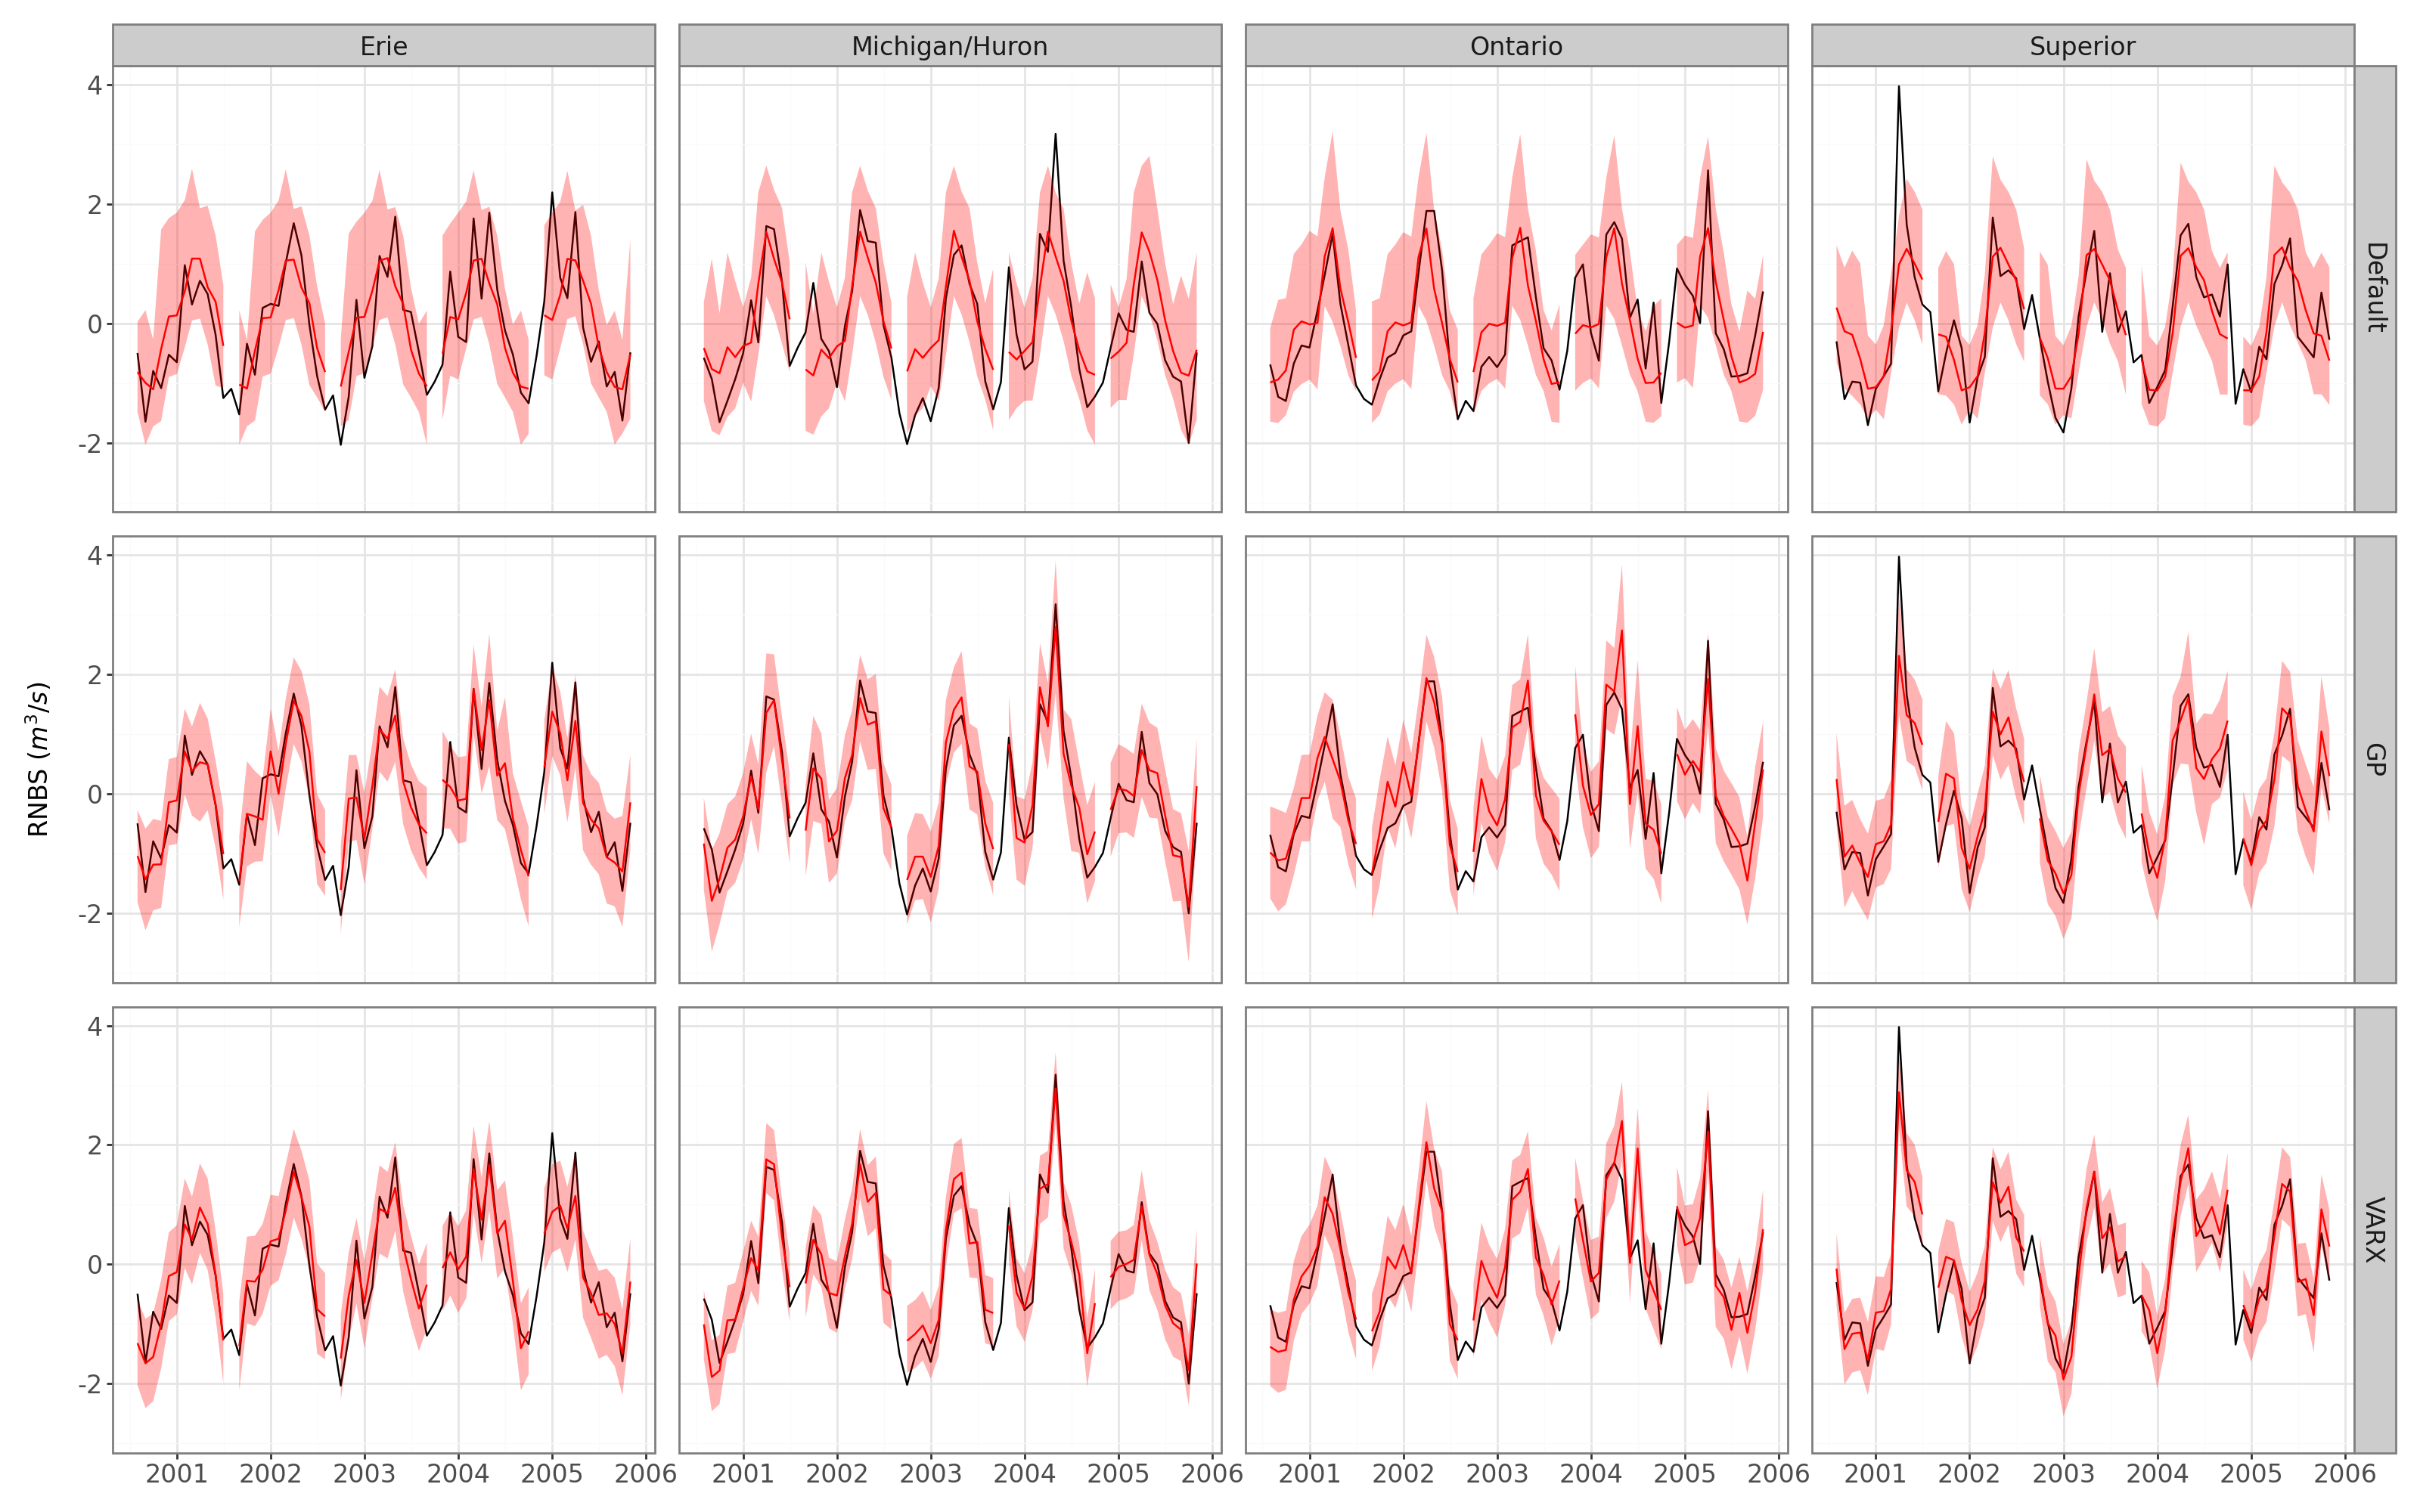

In [13]:
import warnings

warnings.filterwarnings("ignore")

plot_data = cv_results_12[cv_results_12["split"] <= 6].reset_index()
plot_data = plot_data[
    plot_data["model"].isin(["GP_Matern", "VARX", "Default"])
]


def facet_rename(x):
    labels = {
        "eri": "Erie",
        "sup": "Superior",
        "mic_hur": "Michigan/Huron",
        "ont": "Ontario",
        "GP_Matern": "GP",
    }
    return labels.get(x, x)


(
    ggplot(data=plot_data, mapping=aes(x="Date", y="mean", group="split"))
    + geom_line(
        data=y.to_dataframe(name="rnbs").reset_index(),
        mapping=aes(x="Date", y="rnbs"),
        color="black",
        inherit_aes=False,
    )
    + geom_line(color="red")
    + facet_grid("model~lake", labeller=facet_rename)
    + scale_x_datetime(
        limits=[plot_data.Date.min(), plot_data.Date.max()],
        labels=date_format(fmt="%Y"),
        breaks=date_breaks("1 year"),
    )
    + geom_ribbon(
        mapping=aes(x="Date", ymin="lower", ymax="upper"), alpha=0.3, fill="red"
    )
    + ylab("RNBS $\\left(m^3/s\\right)$")
    + theme_bw()
    + theme(
        text=element_text(size=12), figure_size=(16, 10), axis_title_x=element_blank()
    )
)

In [14]:
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month, cv_results_12["Date"].dt.month_name()]
).apply(summarize)

rmse   mae  mape  variance   bias  coverage  interval_len  \
Date Date                                                                   
1    January   0.496 0.378 2.989     0.233  0.113     0.857         1.616   
2    February  0.333 0.272 3.843     0.099  0.106     0.986         1.660   
3    March     0.343 0.269 0.785     0.110  0.088     0.986         1.775   
4    April     0.624 0.407 0.421     0.317 -0.270     0.900         1.875   
5    May       0.509 0.374 0.580     0.255 -0.066     0.921         1.869   
6    June      0.400 0.324 2.886     0.160  0.023     0.950         1.668   
7    July      0.376 0.292 1.188     0.136  0.075     0.957         1.608   
8    August    0.377 0.309 0.846     0.127  0.123     0.929         1.546   
9    September 0.511 0.411 0.854     0.257  0.062     0.843         1.726   
10   October   0.514 0.425 0.799     0.235  0.170     0.857         1.790   
11   November  0.553 0.438 3.651     0.220  0.292     0.900         1.896   
12   December  0.460 0.389 7.651     0.207 -0.067     0.900         1.644   

                crps       N     r2  
Date Date                            
1    January   0.271 140.000  0.480  
2    February  0.192 140.000  0.670  
3    March     0.195 140.000  0.726  
4    April     0.308 140.000 -0.876  
5    May       0.267 140.000  0.448  
6    June      0.227 140.000  0.412  
7    July      0.208 140.000  0.656  
8    August    0.217 140.000  0.470  
9    September 0.293 140.000  0.074  
10   October   0.291 140.000  0.483  
11   November  0.314 140.000  0.119  
12   December  0.269 140.000  0.264

In [15]:
cv_results_12.groupby(["months_ahead", cv_results_12["model"]]).apply(summarize)
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month_name(), cv_results_12["model"]]
).apply(summarize)

rmse   mae  mape  variance   bias  coverage  \
Date      model                                                       
April     BoostedTrees 0.617 0.424 0.542     0.210 -0.412     0.750   
          Default      0.814 0.544 0.465     0.630 -0.179     0.950   
          GP_Matern    0.518 0.360 0.384     0.189 -0.281     0.950   
          MultitaskGP  0.668 0.442 0.596     0.346 -0.315     0.950   
          RF           0.712 0.409 0.334     0.436 -0.267     0.900   
...                      ...   ...   ...       ...    ...       ...   
September GP_Matern    0.458 0.371 0.865     0.209  0.014     0.900   
          MultitaskGP  0.477 0.403 0.878     0.226  0.039     0.900   
          RF           0.553 0.452 0.812     0.299  0.083     0.900   
          SimpleLM     0.498 0.384 0.567     0.246  0.049     0.800   
          VARX         0.477 0.374 0.707     0.227  0.009     0.700   

                        interval_len  crps      N      r2  
Date      model                                            
April     BoostedTrees         2.461 0.314 20.000  -0.981  
          Default              2.426 0.413 20.000 -10.459  
          GP_Matern            1.578 0.262 20.000   0.003  
          MultitaskGP          1.672 0.321 20.000  -0.666  
          RF                   2.239 0.344 20.000  -6.756  
...                              ...   ...    ...     ...  
September GP_Matern            1.578 0.262 20.000   0.320  
          MultitaskGP          1.715 0.276 20.000   0.193  
          RF                   1.692 0.323 20.000  -0.705  
          SimpleLM             1.464 0.287 20.000   0.414  
          VARX                 1.289 0.273 20.000   0.408  

[84 rows x 10 columns]

In [16]:
grp_data = cv_results_12
grp_data.groupby(["months_ahead", "model"]).apply(summarize)[
    ["rmse", "coverage", "crps", "r2"]
]

rmse  coverage  crps     r2
months_ahead model                                    
1            BoostedTrees 0.480     0.750 0.279  0.639
             Default      0.674     0.900 0.387 -1.775
             GP_Matern    0.421     0.950 0.242  0.732
             MultitaskGP  0.436     0.900 0.249  0.690
             RF           0.541     0.950 0.321  0.272
...                         ...       ...   ...    ...
12           GP_Matern    0.376     1.000 0.219  0.714
             MultitaskGP  0.385     1.000 0.225  0.689
             RF           0.452     1.000 0.256  0.049
             SimpleLM     0.404     0.900 0.229  0.612
             VARX         0.453     0.800 0.266  0.561

[84 rows x 4 columns]

In [17]:
# lake_data.sel(Date=slice(None, test_data.indexes["Date"].min()))
import numpy as np

steps_ahead = xr.DataArray(
    np.arange(1, 13), dims=["steps_ahead"], coords={"steps_ahead": np.arange(1, 13)}
)

pred_set = []
test_results_dir = Path("_scratch_all_types/results")
test_results_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    logging.info("Now running preds for model: ", name)
    for i in range(test_data.shape[0]):
        try:
            preds = pd.read_csv(test_results_dir / f"{name}_{i}.csv")
            preds["Date"] = pd.to_datetime(preds["Date"])
            logging.info(f"----------Reading preds for model {name}----------")
        except FileNotFoundError:
            logging.info(f"----------Running preds for model {name}----------")
            logging.info(f"Step {i}")
            add_step = min(test_data.shape[0] - i, 12)
            pred_x, pred_y = xr.concat(
                [X, test_x[: (i + add_step)]], "Date"
            ), xr.concat([y, test_y[: i + add_step]], "Date")
            preds = all_models[name].predict(
                X=pred_x, y=pred_y, forecast_steps=add_step
            )
            steps_ahead = pd.Series(
                np.arange(1, add_step + 1), index=preds.indexes["Date"]
            )
            preds = (
                preds.to_dataframe(dim_order=["Date", "lake", "value"])
                .reset_index(["lake", "value"])
                .assign(model=name)
            )
            preds["steps_ahead"] = steps_ahead
            preds.to_csv(test_results_dir / f"{name}_{i}.csv")
        pred_set.append(preds.reset_index())

--- Logging error ---
Traceback (most recent call last):
  File "/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/logging/__init__.py", line 1160, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/logging/__init__.py", line 999, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/logging/__init__.py", line 703, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/logging/__init__.py", line 392, in getMessage
    msg = msg % self.args
          ~~~~^~~~~~~~~~~
TypeError: not all arguments converted during string formatting
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/site-packages/ipykernel_lau

In [21]:
all_preds = pd.concat(pred_set)
all_preds = all_preds.pivot(
    index=["Date", "lake", "model", "steps_ahead"], columns="value", values="forecasts"
).reset_index()

test_preds = all_preds.merge(test_y.to_dataframe(name="true").reset_index())

test_preds.head()


Date lake         model  steps_ahead  NaN  lower   mean   std  upper  \
0 2006-06-01  eri  BoostedTrees        1.000  NaN -0.730 -0.320 0.303  0.480   
1 2006-06-01  eri       Default        1.000  NaN -1.004  0.330 0.694  1.467   
2 2006-06-01  eri     GP_Matern        1.000  NaN -1.059 -0.295 0.390  0.470   
3 2006-06-01  eri   MultitaskGP        1.000  NaN -1.199 -0.336 0.432  0.527   
4 2006-06-01  eri            RF        1.000  NaN -1.249 -0.221 0.551  0.645   

   true  
0 0.079  
1 0.079  
2 0.079  
3 0.079  
4 0.079

In [22]:
rmse_df = (
    test_preds.groupby([test_preds.Date.dt.month, "model", "lake", "steps_ahead"])
    .apply(summarize)
    .reset_index()
)

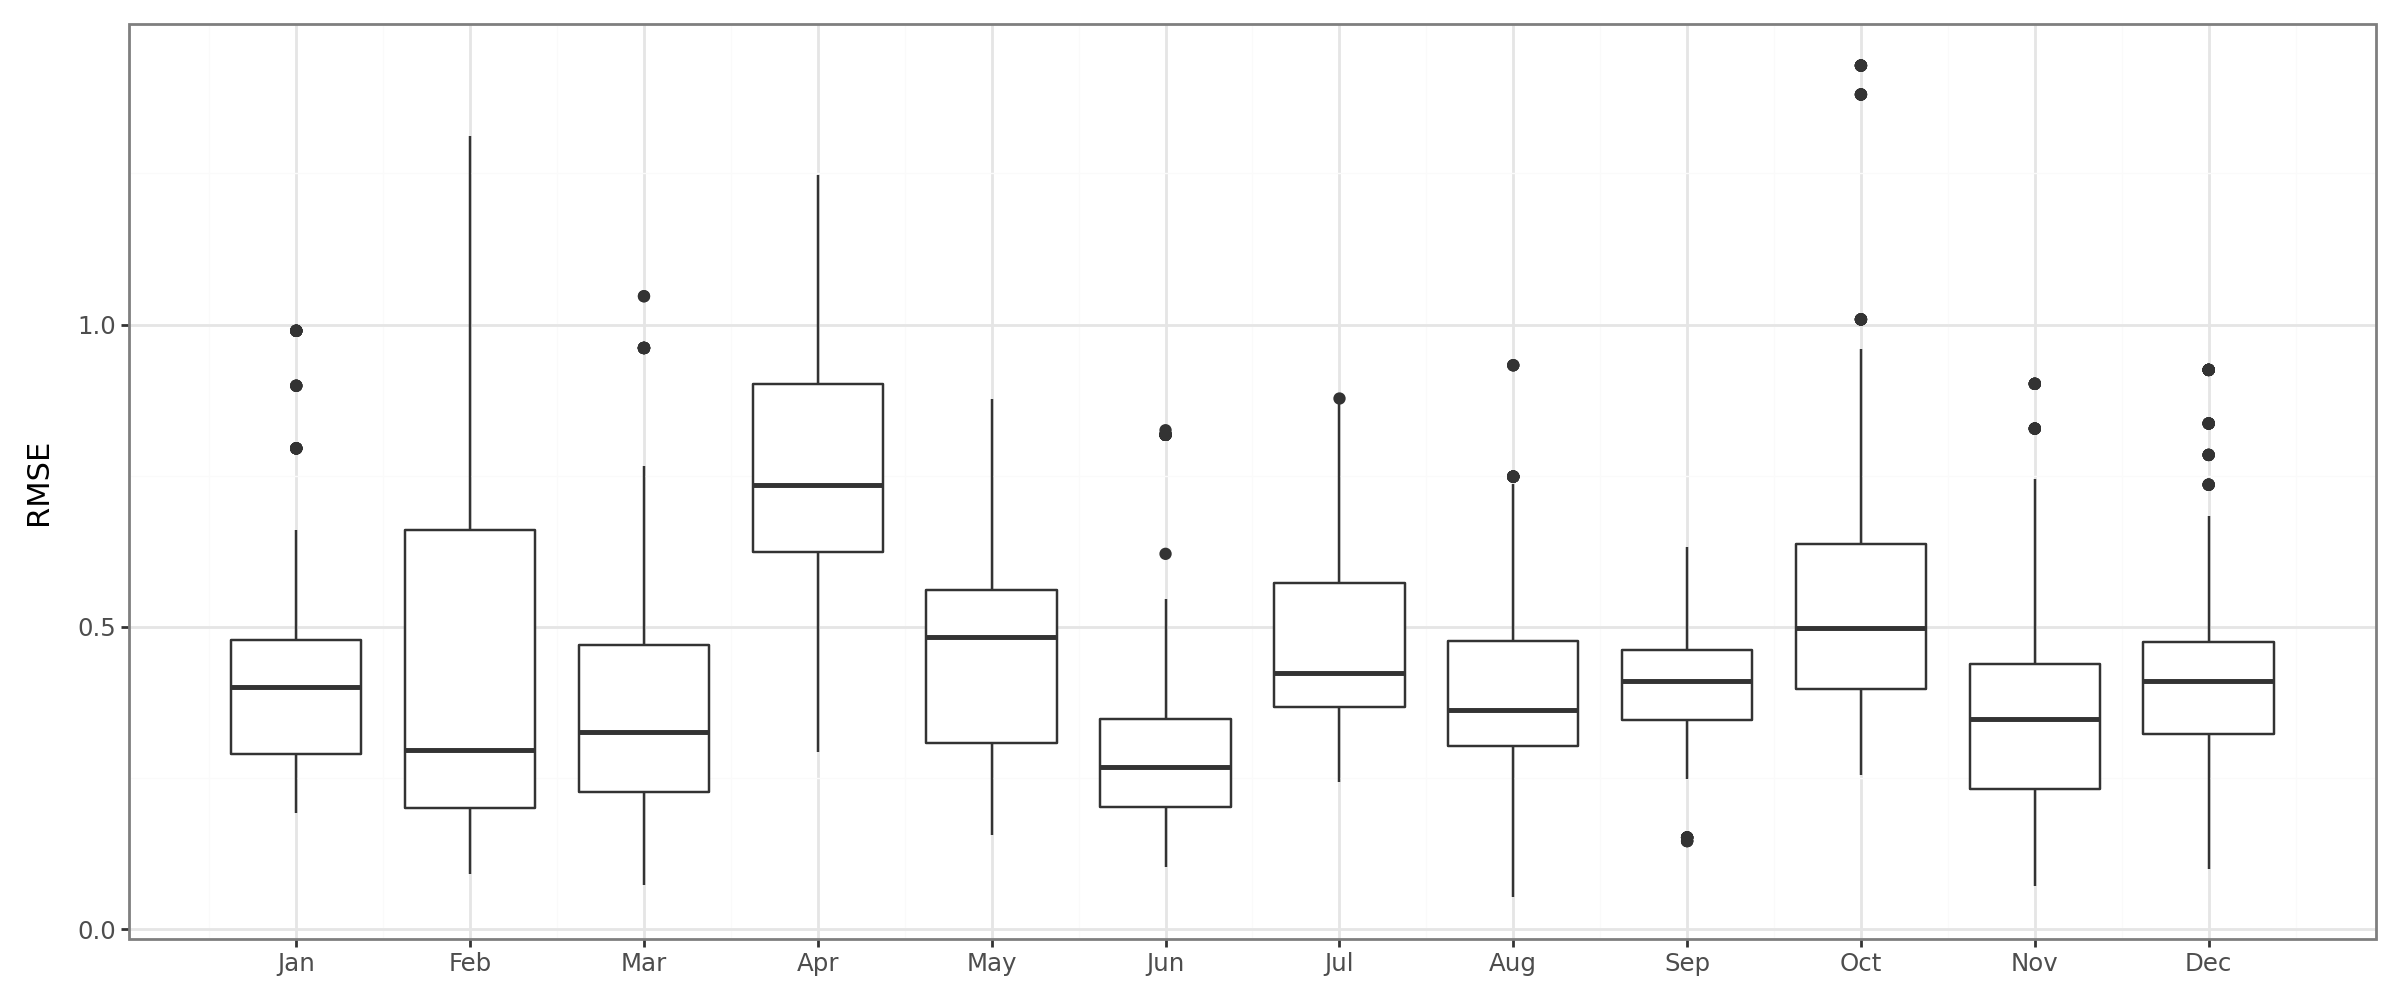

In [23]:
(
    ggplot(data=rmse_df, mapping=aes(x="Date", y="rmse", group="Date"))
    + geom_boxplot()
    + scale_x_continuous(breaks=np.arange(1, 13), labels=calendar.month_abbr[1:])
    + theme_bw()
    + ylab("RMSE")
    + theme(axis_title_x=element_blank(), figure_size=(12, 5))
)

In [24]:
melted_data = test_preds.set_index(["Date", "lake", "model", "steps_ahead"]).melt(
    ignore_index=False
)
transformed_data = [
    y_scaler.inverse_transform(
        df.reset_index().pivot(
            index=["Date", "model", "steps_ahead"], columns="lake", values="value"
        )[["sup", "mic_hur", "eri", "ont"]]
    )
    .melt(ignore_index=False, value_name=grp[-1])
    .set_index("lake", append=True)
    for grp, df in melted_data.groupby(["variable"])
]

transformed_vals = pd.concat(transformed_data, axis=1).reset_index()

True


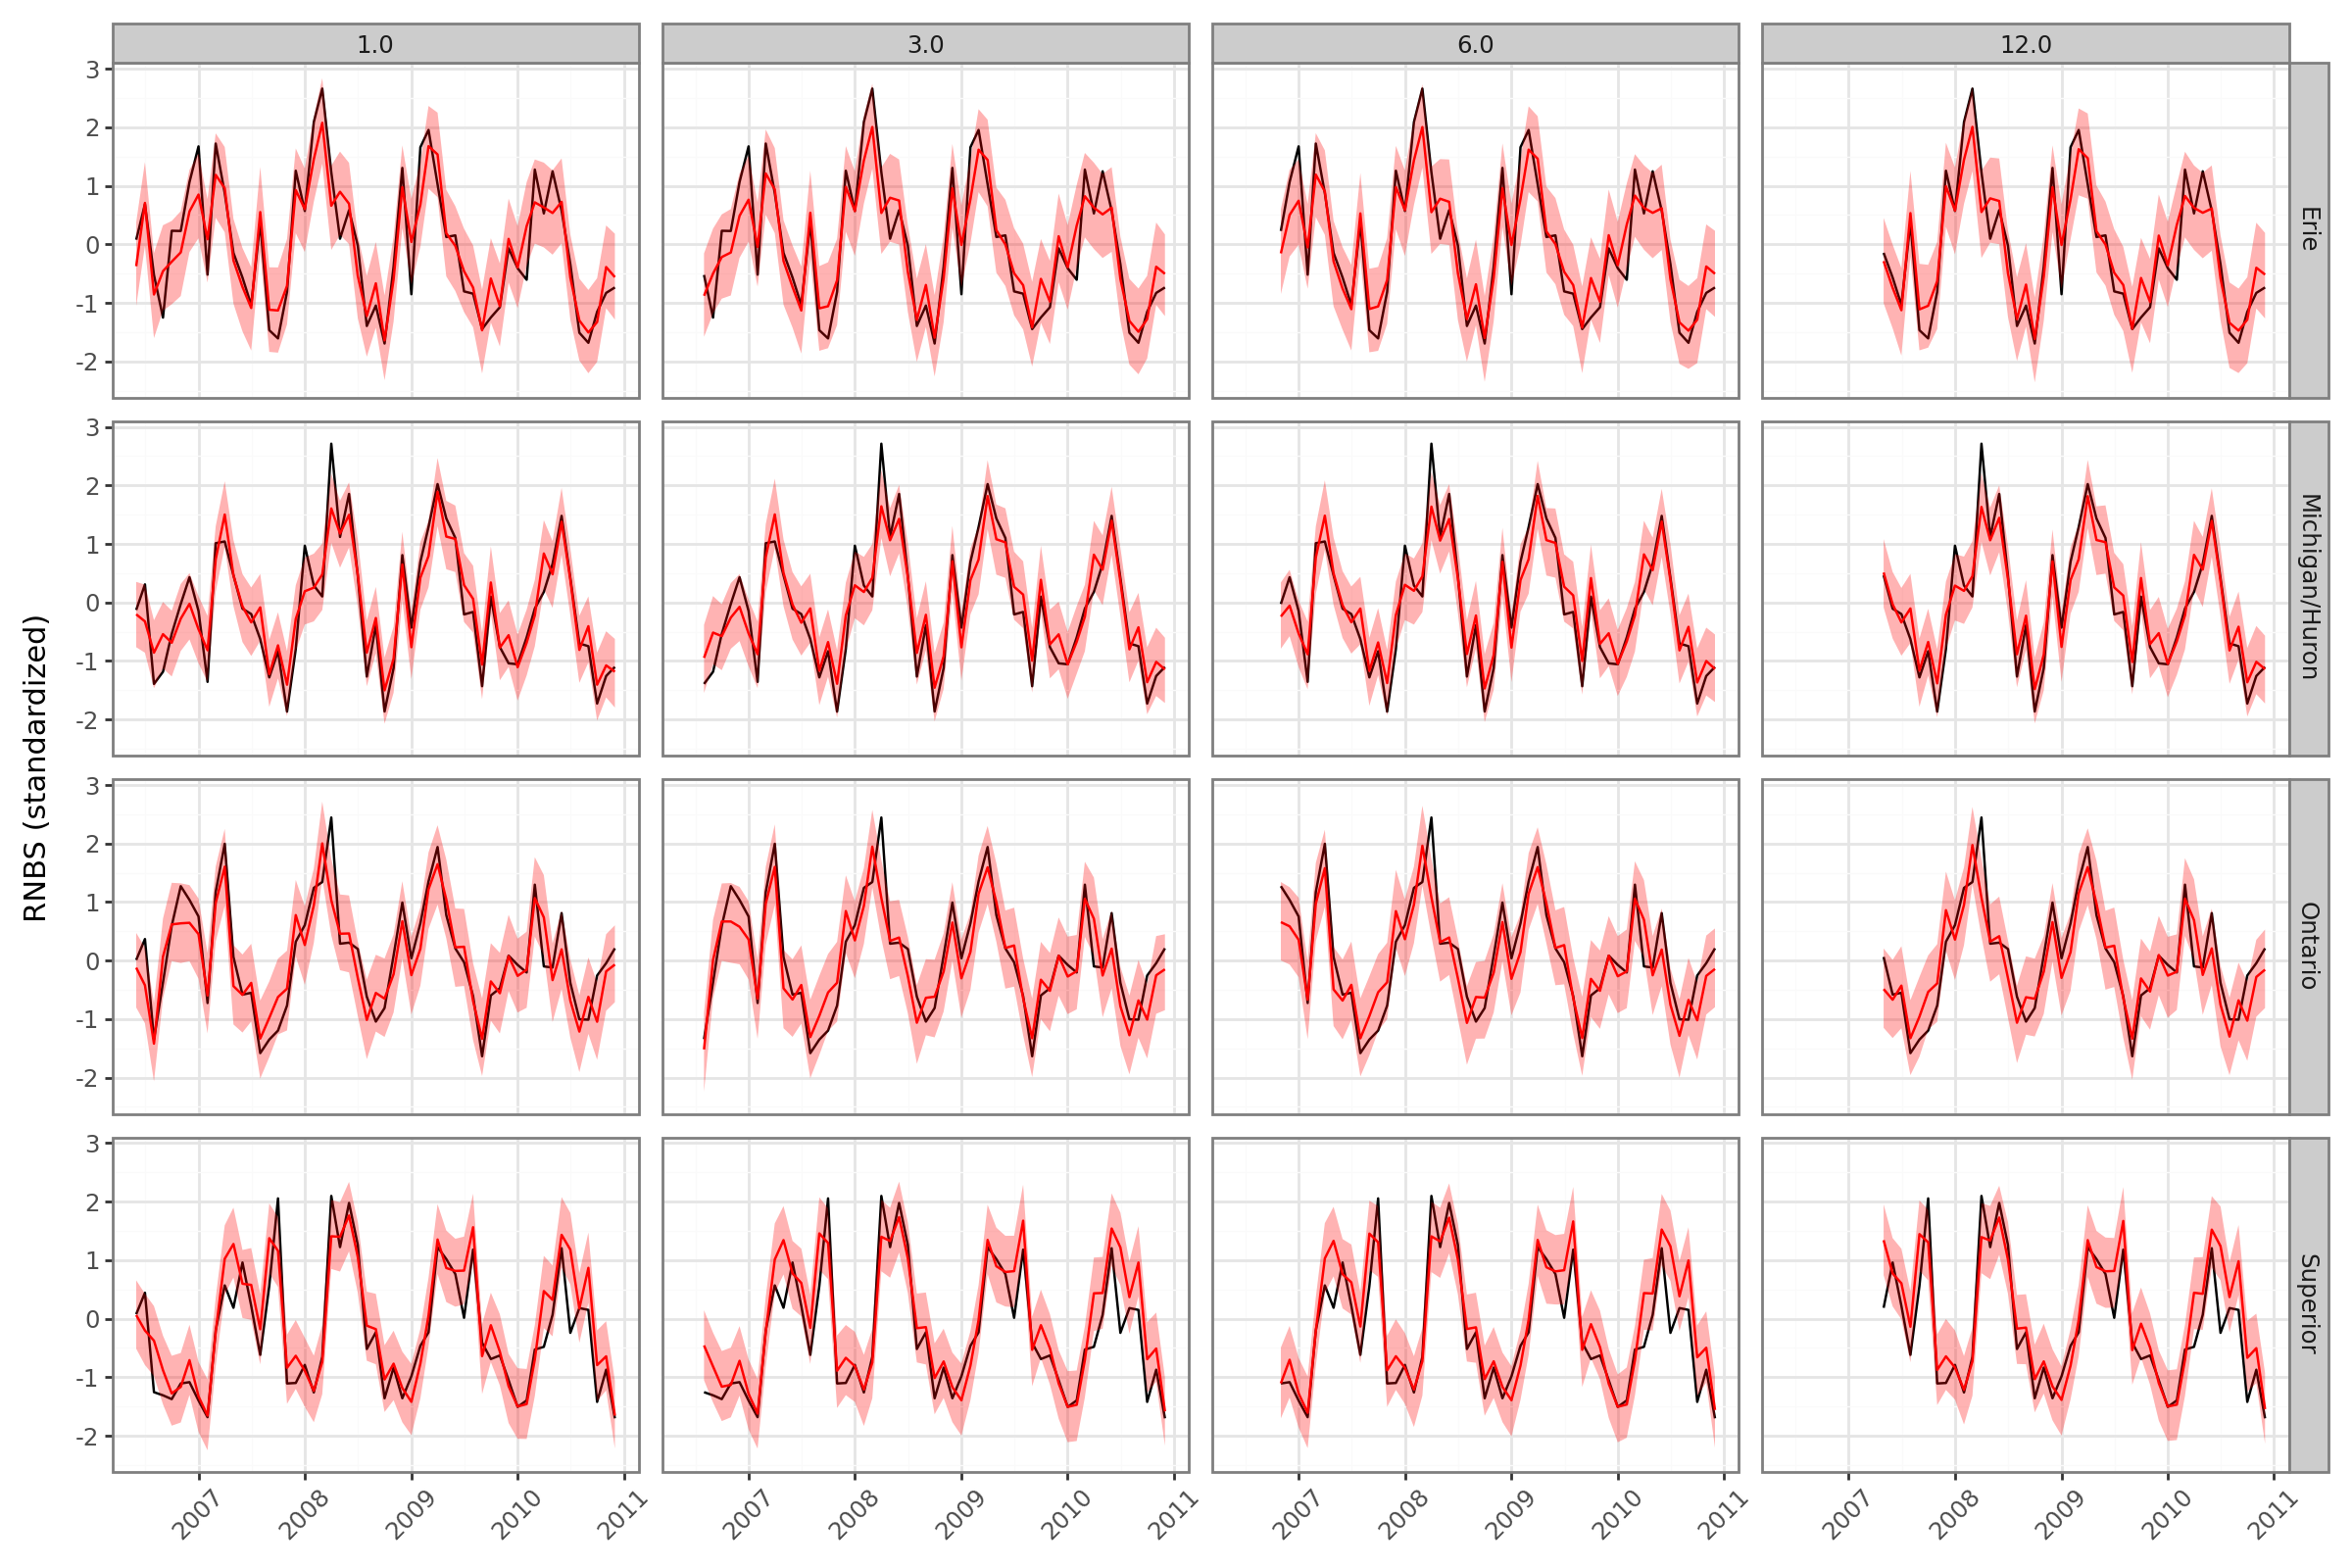

In [25]:
plot_data = test_preds[
    (test_preds["model"] == "VARX") & test_preds["steps_ahead"].isin([1, 3, 6, 12])
]

print((test_preds["model"] == "VARX").any())

(
    ggplot(data=plot_data, mapping=aes(x="Date", y="true"))
    + facet_grid("lake~steps_ahead", labeller=rename_lakes)
    + geom_line()
    + geom_line(mapping=aes(y="mean"), color="red")
    + theme_bw()
    + geom_ribbon(aes(ymin="lower", ymax="upper", y="mean"), fill="red", alpha=0.3)
    + scale_x_datetime(
        limits=[plot_data.Date.min(), plot_data.Date.max()],
        labels=date_format(fmt="%Y"),
        breaks=date_breaks("1 year"),
    )
    + theme(axis_text_x=element_text(angle=45), axis_title_x=element_blank(), figure_size=(12, 8))
    + ylab("RNBS (standardized)")
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


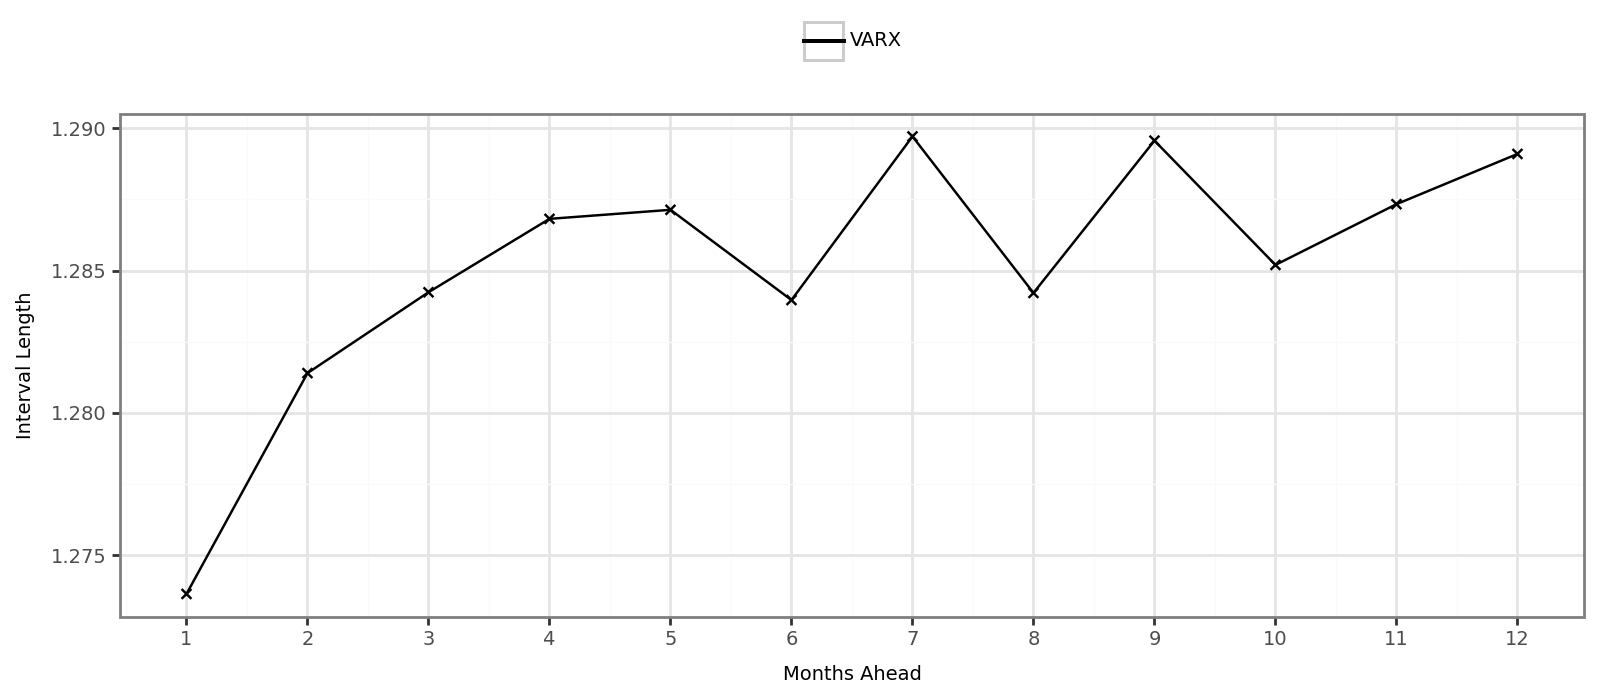

In [29]:
plot_data = test_preds.groupby(["model", "steps_ahead"]).apply(summarize).reset_index()
plot_data = plot_data[plot_data["model"].isin(["VARX", "NARX"])]

(
    ggplot(
        data=plot_data, mapping=aes(x="steps_ahead", y="interval_len", linetype="model")
    )
    + geom_line()
    + theme_bw()
    + geom_point(shape="x")
    + theme(
        legend_position="top",
        legend_title=element_blank(),
        figure_size=(8, 3.5),
        text=element_text(size=7),
    )
    + scale_color_brewer(palette="Dark2", type="qual", name="Model")
    + scale_x_continuous(breaks=np.arange(1, 13))
    + ylab("Interval Length")
    + xlab("Months Ahead")
)

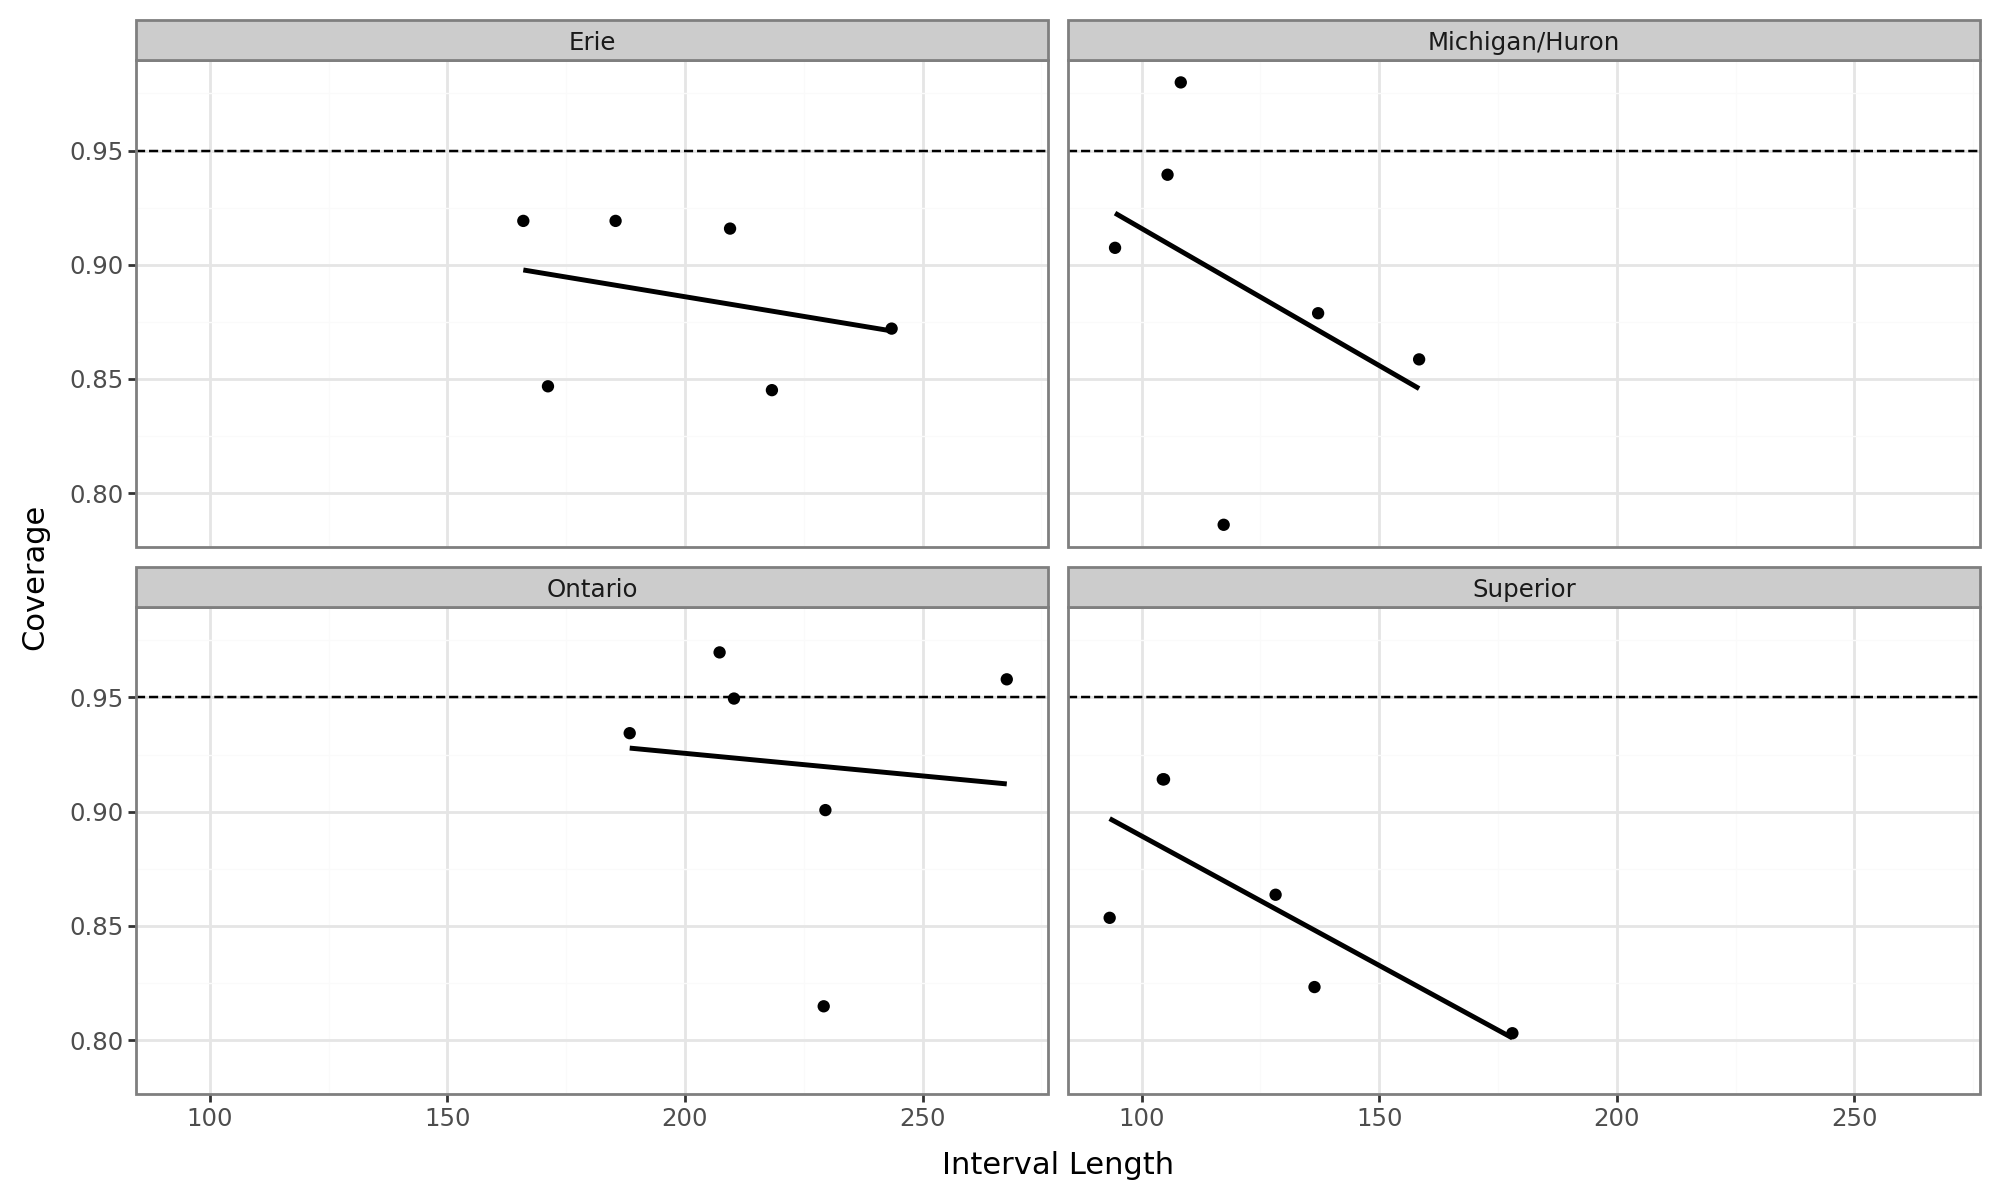

In [42]:
scatter_data = (
    transformed_vals.groupby(["model", "lake"]).apply(summarize).reset_index()
)
scatter_data["method_type"] = np.where(
    scatter_data["model"].isin(["VARX", "NARX"]), "AR", "Non-AR"
)
(
    ggplot(data=scatter_data, mapping=aes(x="interval_len", y="coverage"))
    + geom_hline(yintercept=0.95, linetype="--")
    + geom_point()
    + geom_smooth(method="lm", se=False)
    + facet_wrap("~lake", nrow=2, labeller=rename_lakes)
    + theme_bw()
    + theme(legend_position="right", legend_title=element_blank(), figure_size=(10, 6))
    + scale_color_brewer(palette="Dark2", type="qual", name="Method Type")
    + ylab("Coverage")
    + xlab("Interval Length")
)

In [44]:
agg_values = ["coverage", "interval_len"]
lake_table = test_preds.groupby(["model", "lake"]).apply(summarize)[agg_values]

model_display_names = {
    "BoostedTrees": "Boosted Trees",
    "SimpleLM": "Linear Model",
    "Default": "Default Ensemble",
    "GP_Matern": "Gaussian Process",
    "MultitaskGP": "Multitask GP",
    "NARX": "NARX",
    "VARX": "VARX",
    "RF": "Random Forest",
}
lake_table.index = pd.MultiIndex.from_tuples(
    [
        (model_display_names[model], rename_lakes(lake))
        for model, lake in lake_table.index
    ],
    names=["model", "lake"],
)

lake_table = (
    lake_table.melt(ignore_index=False)
    .reset_index()
    .pivot_table(index=["model", "variable"], columns=["lake"], values="value")
)

full_table = test_preds.groupby("model").apply(summarize)[agg_values]
full_table.index = pd.Index(
    [model_display_names[model] for model in full_table.index], name="model"
)

full_table = (
    full_table.melt(ignore_index=False)
    .reset_index()
    .assign(lake="All")
    .pivot_table(index=["model", "variable"], columns=["lake"], values="value")
)
merged_table = lake_table.merge(full_table, left_index=True, right_index=True)

print(
    merged_table.melt(ignore_index=False)
    .reset_index()
    .pivot(index=["model"], columns=["lake", "variable"], values="value")
    .to_latex(float_format="%0.3f")
)

\begin{tabular}{lrrrrrrrrrr}
\toprule
lake & \multicolumn{2}{r}{Erie} & \multicolumn{2}{r}{Michigan/Huron} & \multicolumn{2}{r}{Ontario} & \multicolumn{2}{r}{Superior} & \multicolumn{2}{r}{All} \\
variable & coverage & interval_len & coverage & interval_len & coverage & interval_len & coverage & interval_len & coverage & interval_len \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
Boosted Trees & 0.845 & 2.004 & 0.786 & 1.651 & 0.815 & 1.854 & 0.803 & 2.591 & 0.812 & 2.025 \\
Default Ensemble & 0.872 & 2.236 & 0.859 & 2.230 & 0.958 & 2.166 & 0.823 & 1.985 & 0.878 & 2.154 \\
Gaussian Process & 0.919 & 1.524 & 0.980 & 1.524 & 0.934 & 1.524 & 0.914 & 1.524 & 0.937 & 1.524 \\
Linear Model & 0.847 & 1.572 & 0.907 & 1.329 & 0.970 & 1.677 & 0.854 & 1.358 & 0.894 & 1.484 \\
Multitask GP & 0.919 & 1.702 & 0.939 & 1.485 & 0.949 & 1.702 & 0.914 & 1.520 & 0.931 & 1.602 \\
Random Forest & 0.916 & 1.923 & 0.879 & 1.931 & 0.901 & 1.857 & 0.864 & 1.866 & 0.890 & 1.894 \\
\bottomrule
\end{tabular}



In [45]:
test_preds.groupby("model").apply(summarize).sort_values("rmse", ascending=True)

rmse   mae  mape  variance  bias  coverage  interval_len  crps  \
model                                                                          
GP_Matern    0.422 0.321 1.329     0.177 0.034     0.937         1.524 0.231   
MultitaskGP  0.448 0.343 1.257     0.200 0.031     0.931         1.602 0.247   
SimpleLM     0.458 0.358 1.235     0.208 0.045     0.894         1.484 0.256   
BoostedTrees 0.470 0.362 1.083     0.221 0.017     0.812         2.025 0.266   
RF           0.522 0.422 1.252     0.270 0.054     0.890         1.894 0.295   
Default      0.683 0.543 2.941     0.465 0.037     0.878         2.154 0.382   

                     N    r2  
model                         
GP_Matern    2,376.000 0.786  
MultitaskGP  2,376.000 0.755  
SimpleLM     2,376.000 0.765  
BoostedTrees 2,376.000 0.684  
RF           2,376.000 0.603  
Default      2,376.000 0.224

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


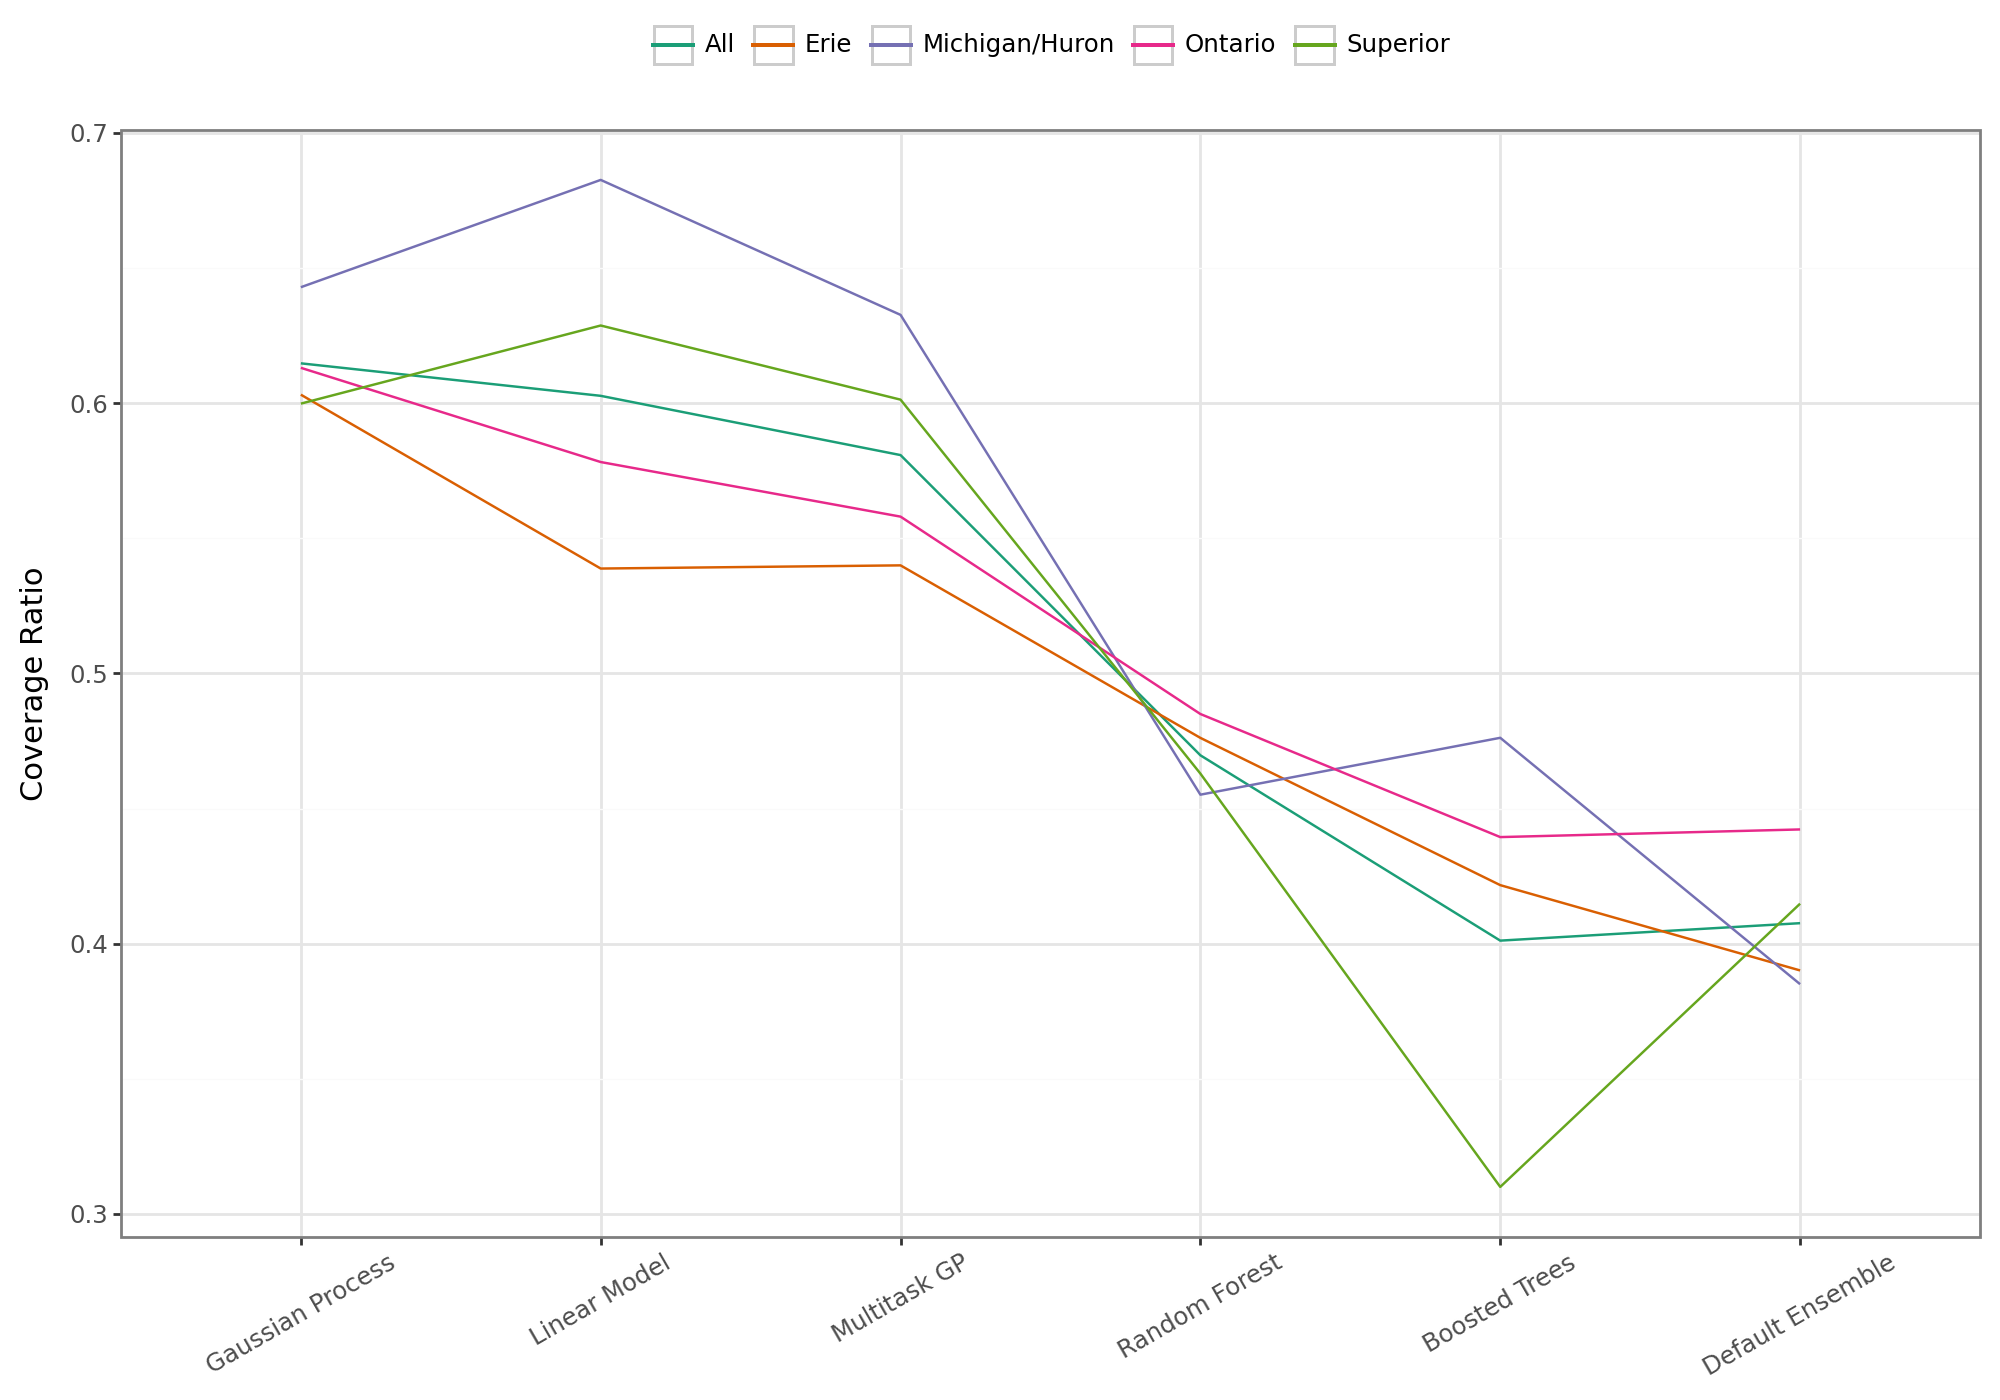

In [47]:
ratios = (
    merged_table.melt(ignore_index=False)
    .reset_index()
    .pivot(columns=["variable"], index=["model", "lake"], values="value")
)
ratios["coverage_ratio"] = ratios["coverage"] / ratios["interval_len"]
plot_data = ratios.sort_values(["lake", "model"], ascending=False).reset_index()

(
    ggplot(
        data=plot_data,
        mapping=aes(
            x="reorder(model, -coverage_ratio)",
            y="coverage_ratio",
            group="lake",
            color="lake",
        ),
    )
    + geom_line()
    + scale_color_brewer(palette="Dark2", type="qual")
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=30),
        axis_title_x=element_blank(),
        figure_size=(10, 7.0),
        legend_position="top",
        legend_title=element_blank(),
    )
    + ylab("Coverage Ratio")
    # + guides(color=guide_legend(title=element_blank()))
)

In [51]:
plot_data = (
    test_preds[test_preds["model"].isin(["VARX", "NARX"])]
    .groupby(["model", "steps_ahead"])
    .apply(summarize)
    .reset_index()
)
plot_data["cov_ratio"] = plot_data["coverage"] / plot_data["interval_len"]

(
    ggplot(
        data=plot_data, mapping=aes(x="steps_ahead", y="cov_ratio", linetype="model")
    )
    + geom_line()
    + theme_bw()
    + scale_x_continuous(breaks=np.arange(1, 13))
)

ValueError: cannot insert steps_ahead, already exists